In [1]:
from dotenv import load_dotenv
import io
from io import BytesIO
from PIL import Image

env_path = '/teamspace/studios/this_studio/Deeplab/credentials.env'
load_dotenv(dotenv_path=env_path)
import boto3
%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *
bucket = get_s3_bucket('treetracker-training-images')
print(type(bucket)) # /teamspace/studios/this_studio/Deeplab/production_sam_lora_annotations

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab
<class 'boto3.resources.factory.s3.Bucket'>


In [2]:
print(bucket)
import matplotlib.pyplot as plt

s3.Bucket(name='treetracker-training-images')


In [3]:
sample_objects = bucket.objects.filter(Prefix='production_large_lora_sam_annotations/samples/')
mask_objects = bucket.objects.filter(Prefix='production_large_lora_sam_annotations/binary_masks/')


sample_paths = []
mask_paths = []

for obj in sample_objects:
  sample_paths.append(obj.key)

for obj in mask_objects:
  mask_paths.append(obj.key)

print("masks - " + str(len(mask_paths)))
print("samples - " + str(len(sample_paths)))

masks - 102
samples - 102


In [4]:
print(sample_paths[0])

production_large_lora_sam_annotations/samples/production_training_0.jpg


In [5]:
import os
print(os.path.split(sample_paths[0])[0])

production_large_lora_sam_annotations/samples


In [6]:
def show_mask(img_np, pred, input_box = None):
    plt.figure(figsize=(10, 10))
    # Create a blue mask based on the prediction
    blue_mask = np.zeros_like(img_np)
    blue_mask[:, :, 2] = pred * 255

    # Plot the image and the mask overlay
    plt.imshow(img_np)
    plt.imshow(blue_mask, alpha=0.7)
    if input_box is not None:
        show_box(input_box, plt.gca())

    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.show()
    plt.close()

def check_mask(to_read, my_bucket = bucket, dataset_path = '/teamspace/studios/this_studio/Deeplab/production_sam_lora_annotations'):
    mask_path = to_read.replace("samples", "binary_masks").replace(".jpg", "_binarymask.jpg")
    s3_sample_object = bucket.Object(to_read).get()
    sample = flip(Image.open(io.BytesIO(s3_sample_object['Body'].read())))
    s3_mask_object = bucket.Object(mask_path).get()
    mask = flip(Image.open(io.BytesIO(s3_mask_object['Body'].read())))

    threshold = 128  # You can adjust this threshold value as needed
    binary_image = mask.point(lambda p: p > threshold and 255)

    # Convert the binary image to a numpy array
    binary_array = np.array(binary_image)

    # Convert to binary values (0 and 1) instead of 0 and 255
    binary_array = np.where(binary_array == 255, 1, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(sample)
    plt.show()
    cleaned_mask_crf = apply_dense_crf(np.array(sample),binary_array*255)
    
    show_mask(np.array(sample),binary_array)
    print('cleaned mask:')
    show_mask(np.array(sample),cleaned_mask_crf)
    do = input('enter 1 to use normal sample, 2 to use crf version.')
    if do == '1':
        sample.save(os.path.join(dataset_path,'samples',os.path.basename(to_read)))
        mask.save(os.path.join(dataset_path,'binary_masks',os.path.basename(mask_path)))
    elif do == '2':
        sample.save(os.path.join(dataset_path,'samples',os.path.basename(to_read)))
        final_mask = Image.fromarray((cleaned_mask_crf * 255).astype(np.uint8))
        final_mask.save(os.path.join(dataset_path,'binary_masks',os.path.basename(mask_path)))




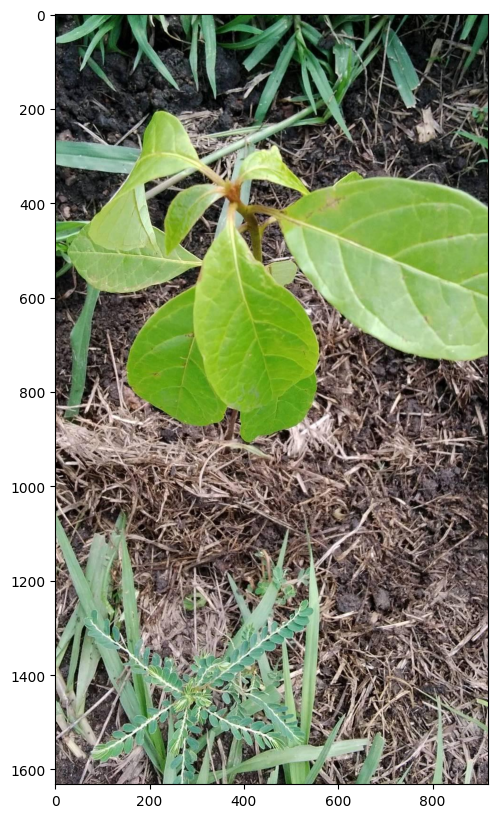

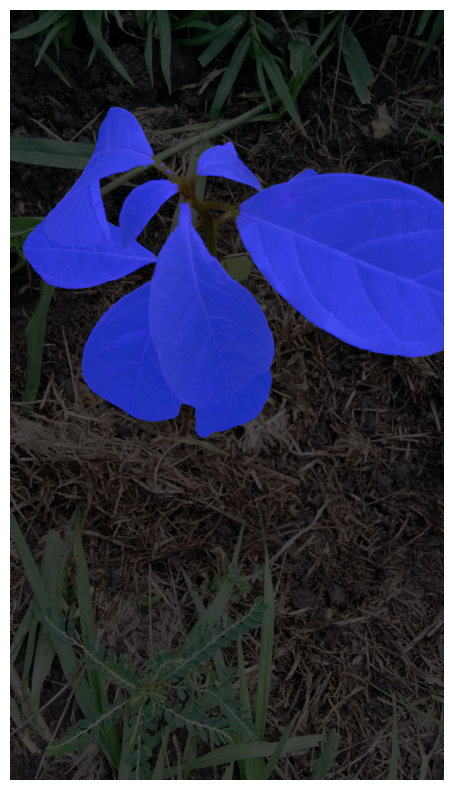

cleaned mask:


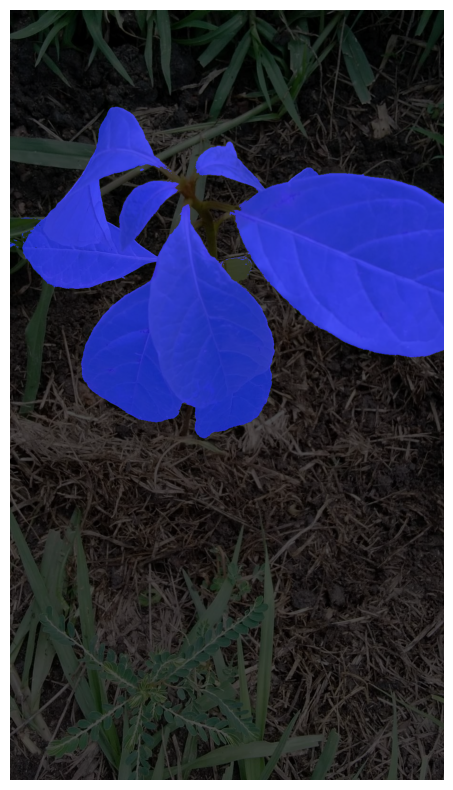

enter 1 to use normal sample, 2 to use crf version. 


In [16]:
check_mask(sample_paths[8])

In [6]:
i = 8

In [28]:
print(i)

28


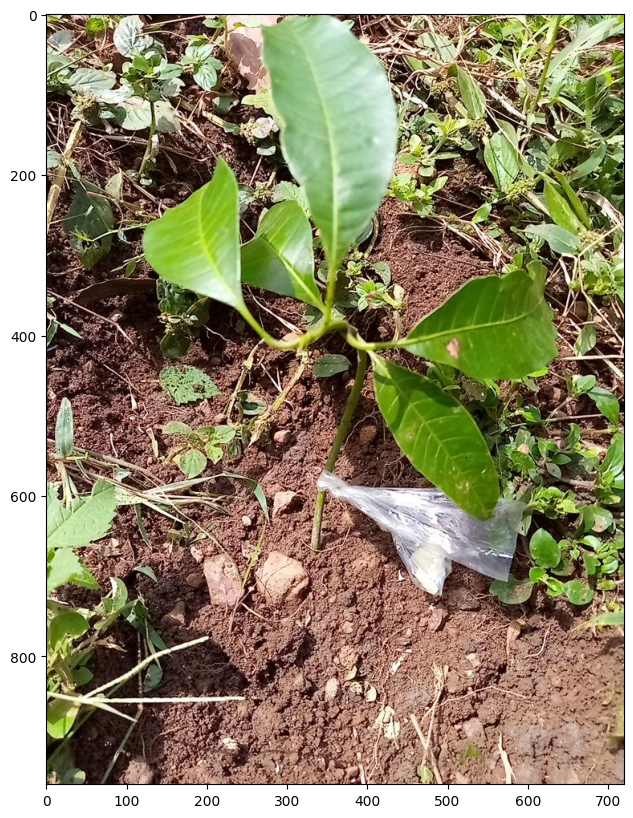

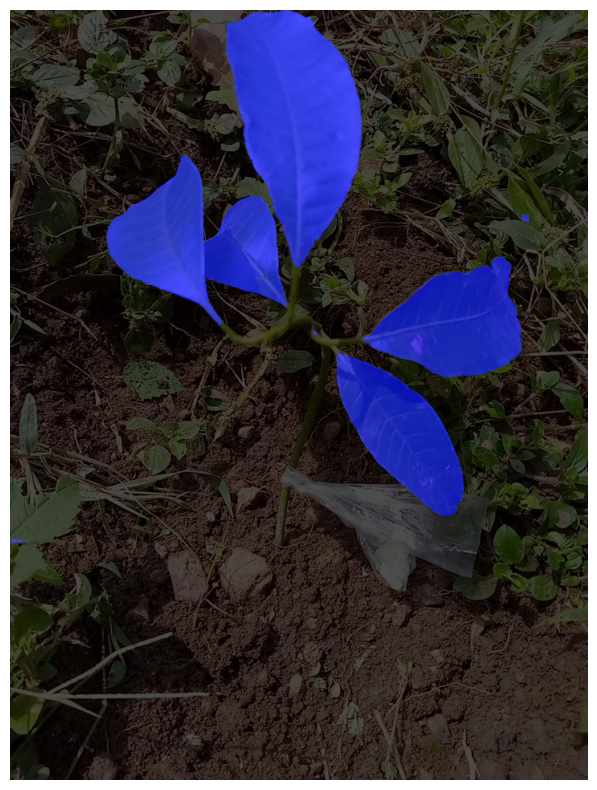

cleaned mask:


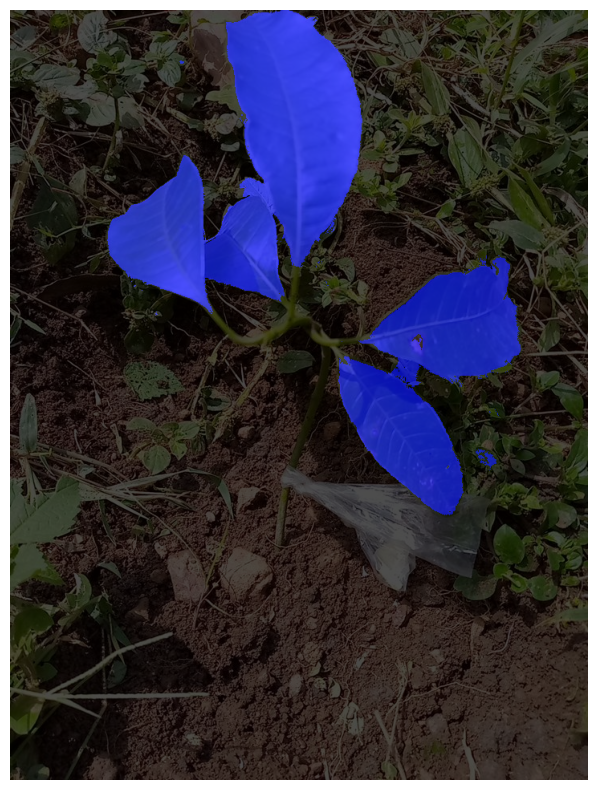

enter 1 to use normal sample, 2 to use crf version. 1


In [36]:
check_mask(sample_paths[i])
i+=1

In [37]:
print(len(os.listdir('/teamspace/studios/this_studio/Deeplab/production_sam_lora_annotations/samples')))

23
